(http://www.newyorksocialdiary.com/) provides a
fascinating lens onto New York's socially well-to-do.  The data forms a natural
social graph for New York's social elite.  Take a look at this page of a recent
run-of-the-mill holiday party:

`http://www.newyorksocialdiary.com/party-pictures/2014/holiday-dinners-and-doers`

Besides the brand-name celebrities, you will notice the photos have carefully
annotated captions labeling those that appear in the photos.  We can think of
this as implicitly implying a social graph: there is a connection between two
individuals if they appear in a picture together.

Fetching the data can be broken down into two phases:

The first step is to crawl the data.  We want photos from parties before
December 1st, 2014.  Go to `http://www.newyorksocialdiary.com/party-pictures`
to see a list of (party) pages.  For each party's page, grab all the captions.

# Hints
  1. Click on the on the index page and see how they change the url.  Use this
     to determine a strategy to get all the data.
  2. Notice that each party has a date on the index page.  Use python's
     `datetime.strptime` function to parse it.
  3. Some captions are not useful: they contain long narrative texts that
     explain the event.  Usually in two stage processes like this, it is better
     to keep more data in the first stage and then filter it out in the second
     stage.  This makes your work more reproducible.  It's usually faster to
     download more data than you need now than to have to redownload more data
     later.
  4. To avoid having to re-scrape every time you run your code, you can
	 consider saving the data to disk, and having the parsing code load a file.
	 A checkpoint library like
	 [ediblepickle](https://pypi.python.org/pypi/ediblepickle/1.1.3) can
     streamline the process so that the time-consuming code will only be run
     when necessary.
  5. HTTP requests can sometimes fail inconsistently. You should expect to
     run into this issue and deal with it as best you can.

Now that you have a list of all captions, you should probably save the data on
disk so that you can quickly retrieve it.  Now comes the parsing part.
  1. Some captions are not useful: they contain long narrative texts that
     explain the event.  Try to find some heuristic rules to separate captions
     that are a list of names from those that are not.  A few heuristics
     include:
      - look for sentences (which have verbs) and as opposed to lists of nouns.
        For example, [nltk does part of speech
        tagging](http://www.nltk.org/book/ch05.html) but it is a little slow.
        There may also be heuristics that accomplish the same thing.
      - Look for commonly repeated threads (e.g. you might end up picking up
        the photo credits or people such as "a friend").
      - Long captions are often not lists of people.  The cutoff is subjective,
        but for grading purposes, *set that cutoff at 250 characters*.
  2. You will want to separate the captions based on various forms of
     punctuation.  Try using `re.split`, which is more sophisticated than
     `string.split`.
  3. You might find a person named "ra Lebenthal".  There is no one by this
     name.  Can anyone spot what's happening here?
  4. This site is pretty formal and likes to say things like "Mayor Michael
     Bloomberg" after his election but "Michael Bloomberg" before his election.
     Can you find other ('optional') titles that are being used?  They should
     probably be filtered out b/c they ultimately refer to the same person:
     "Michael Bloomberg."
  4. There is a special case you might find where couples are written as eg.
     "John and Mary Smith". You will need to write some extra logic to make
     sure this properly parses to two names: "John Smith" and "Mary Smith".
  5. When parsing names from captions, it can help to look at your output
     frequently and address the problems that you see coming up, iterating
     until you have a list that looks reasonable. This is the approach used
     in the reference solution. Because we can only asymptotically approach
     perfect identification and entity matching, we have to stop somewhere.

**Further considerations (not included in solution)**
  1. Who is Patrick McMullan and should he be included in the results? How would
     you address this?
  2. What else could you do to improve the quality of the graph's information?

For the analysis, we think of the problem in terms of a
[network](http://en.wikipedia.org/wiki/Computer_network) or a
[graph](http://en.wikipedia.org/wiki/Graph_%28mathematics%29).  Any time a pair
of people appear in a photo together, that is considered a link.  What we have
described is more appropriately called an (undirected)
[multigraph](http://en.wikipedia.org/wiki/Multigraph) with no self-loops but
this has an obvious analog in terms of an undirected [weighted
graph](http://en.wikipedia.org/wiki/Graph_%28mathematics%29#Weighted_graph).
In this problem, we will analyze the social graph of the new york social elite.

We recommend using python's `networkx` library.


# Questions

**Checkpoint**
Total number of names found: 113,031
Total number of pairs found: 196,245
Total number of raw captions: 113,325
Total number of valid captions: 102,736

## 1. degree
The simplest question to ask is "who is the most popular"?  The easiest way to
answer this question is to look at how many connections everyone has.  Return
the top 100 people and their degree.  Remember that if an edge of the graph has
weight 2, it counts for 2 in the degree.

**Checkpoint**
Top 100 .describe()
"count": 100.0
"mean": 109.96
"std": 52.4777817343
"min": 71.0
"25%": 79.75
"50%": 91.0
"75%": 120.25
"max": 373.0

## 2. pagerank
A similar way to determine popularity is to look at their
[pagerank](http://en.wikipedia.org/wiki/PageRank).  Pagerank is used for web
ranking and was originally
[patented](http://patft.uspto.gov/netacgi/nph-Parser?patentnumber=6285999) by
Google and is essentially the stationary distribution of a [markov
chain](http://en.wikipedia.org/wiki/Markov_chain) implied by the social graph.

Use 0.85 as the damping parameter so that there is a 15% chance of jumping to
another vertex at random.

**Checkpoint**
Top 100 .describe()
"count": 100.0
"mean": 0.0001841088
"std": 0.0000758068
"min": 0.0001238355
"25%": 0.0001415028
"50%": 0.0001616183
"75%": 0.0001972663
"max": 0.0006085816

## 3. best_friends
Another interesting question is who tend to co-occur with each other.  Give
us the 100 edges with the highest weights.

Google these people and see what their connection is.  Can we use this to
detect instances of infidelity?

**Checkpoint**
Top 100 .describe()
"count": 100.0
"mean": 25.84
"std": 16.0395470855
"min": 14.0
"25%": 16.0
"50%": 19.0
"75%": 29.25
"max": 109.0


In [619]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['savefig.dpi'] = 2 * mpl.rcParams['savefig.dpi']

In [178]:
# Get number of pages
import re
import requests
from bs4 import BeautifulSoup
root_url = 'http://www.newyorksocialdiary.com'
base_url = root_url + '/party-pictures'
response = requests.get(base_url)
soup = BeautifulSoup(response.text)
last_page_field = soup.find('a', attrs={'title': 'Go to last page'})
last_page=int(re.search('(?<=page=)\w+', last_page_field['href']).group(0))

In [216]:
# Get all album links before selected threshold date
from time import strptime
thr_date_str = 'December 1, 2014'
#thr_date_str = 'May 1, 2007'
thr_date = strptime(thr_date_str, "%B %d, %Y")

ok_links=[]
for page_num in range(last_page+1):
    page_url = base_url + '?page=%d' % page_num
    response = requests.get(page_url)
    soup = BeautifulSoup(response.text)
    link_divs = soup.select('span.views-field-title a')
    date_divs = soup.select('span.views-field-created')
    if len(link_divs) != len(date_divs):
        raise ValueError('Number of album links ({n_albums}) different from '.format(n_albums=len(link_divs)) + 
                         'number of found album dates ({n_dates})'.format(n_dates=len(date_divs)))
    dates_links = {}
    for iAlbum in range(len(link_divs)):
        album_date = strptime(date_divs[iAlbum].text, " %A, %B %d, %Y ")
        album_link = link_divs[iAlbum]['href']
        dates_links[album_date] = album_link
    ok_links += [root_url + dates_links[ok_date] for ok_date in dates_links.keys() if ok_date < thr_date]
#views-field-title
#date_divs = soup.find('div', attrs={'class': 'panel-pane pane-node-created'})

In [218]:
from ediblepickle import checkpoint
#import multiplrocessing
import time
# Get all the captions
@checkpoint(key='all_captions.csv', work_dir='.', refresh=False)
def get_all_captions():
    all_captions = []
    for ok_link in ok_links:
        #url = "http://www.newyorksocialdiary.com/party-pictures/2007/music-to-our-ears"
        response = requests.get(ok_link)
        soup = BeautifulSoup(response.text)
        caption_tds = soup.select('div.pane-page-content table td td')
        #soup.find_all("font", attrs={'face': 'Verdana, Arial, Helvetica, sans-serif','size': '1'})
        all_captions += [' '.join(td.text.strip().split()) for td in caption_tds 
                         if td.text.strip() != '' and td.find('script') is None]
    return all_captions

#pool = multiprocessing.Pool(processes=6)

# First call, evaluates the function and saves the results
begin = time.time()
my_captions = get_all_captions()
time_taken = time.time() - begin
print time_taken

# Second call, since the checkpoint exists, the result is loaded from that file and returned.
begin = time.time()
my_captions = get_all_captions()
time_taken = time.time() - begin
print time_taken

511.510752916
210.037039042


In [221]:
import pickle
with open('captions.pickle','w') as f:
    pickle.dump(my_captions, f)

In [ ]:
my_captions = pickle.load(open('afile', 'rb'))

In [784]:
print len(my_captions)
caps100 = my_captions[:100]
caps1000 = my_captions[:1000]
caps10000 = my_captions[:10000]

89956


In [559]:
a ='Hannah Jacobs, Julia Monk, China Machado, and Judith Light'
#a="CMOM Executive Director Andrew Ackerman and Honorary Board Chair Laurie M. Tisch"
a='Paula Zahn, Alex Witt, Robert Desiderio, Daryl Roth, Judith Light, America Ferrara, Herb Hamsher, and Thomas Robert at the 13th Annual Women Who Care Luncheon benefitting United Cerebral Palsy of NYC.'
tokens_withnull = re.split('\s*,+\s*|\s*,*\s*and\s*|\s*,*\s*with\s*', a)
tokens_withnull = re.split(',\ and\ |\ and\ |,\ with\ |\ with\ |,\ ', a)
tokens = [token for token in tokens_withnull if token != '']
print tokens
for t in tokens:
    #print t.split(' ')[:-2]
    print ' '.join(t.split()[:-2])


['Paula Zahn', 'Alex Witt', 'Robert Desiderio', 'Daryl Roth', 'Judith Light', 'America Ferrara', 'Herb Hamsher', 'Thomas Robert at the 13th Annual Women Who Care Luncheon benefitting United Cerebral Palsy of NYC.']







Thomas Robert at the 13th Annual Women Who Care Luncheon benefitting United Cerebral Palsy


In [777]:
def pot_name(token):
    return all(p.replace("'","").istitle() or p.isupper() or p in ['bin', 'bint', 'van', 'du', 'de'] 
               or p.startswith(('Mc','Fitz')) for p in token.split())

def pot_firstname(token):
    return len(token.split()) == 1

def pot_name_startend(token):
    token_parts = token.split()
    return ((pot_name(' '.join(token_parts[:2])) and keep_final(' '.join(token_parts[:2]))) or
            (pot_name(' '.join(token_parts[-2:])) and keep_final(' '.join(token_parts[-2:]))))

def get_name_startend(token):
    token_parts = token.split()
    start_name = ' '.join(token_parts[:2])
    end_name = ' '.join(token_parts[-2:])
    if pot_name(start_name):
        return start_name
    else:
        return end_name

def is_suffix(token):
    return len(token.split()) == 1 and token in ['MD', 'PhD', 'FACS']

def remove_title(fullname):
    mapping = [ ('Dr ', ''), ('Dr. ', ''), ('Mayor ', ''), ('Sir ', ''),
                ('OSL ', ''), ('Chef ', ''), ('CEO ', ''), ('Ambassador ', ''),
                ('Senator ', ''), ('Board Member ', ''), ('Honorees ', ''),
                ('Honoree ', ''), ('Trustee ', ''), ('Chairman ', ''),
                ('R. ', ''), ('Chairmen ', ''), ('Vice ', ''), ('Gala ', ''),
                ('Chair ', ''), ('Chairs ', ''), ('Co-Chair ', ''),
                ('Chairwoman ', ''), ('Chairwomen ', ''), ('Chairman-Elect ', ''),
                ('Museum ', ''), ('Frick ', ''), ('President ', ''), ('Governor ', ''),
                ('Executive ', ''), ('Commissioner ', ''), ('Countess ', ''),
                ('Curator ', ''), ('Center ', ''), ('Provost ', ''), ('Board ', ''),
                ('Hon. ', ''), ('DJ ', ''), ('Mr. ', ''), ('New York ', ''), ('New York. ', ''),
                ('New School ', ''), ('City ', ''), ('Chapter ', ''), ('Community ', ''), ('Trust ', ''),
                ('Miss ', ''), ('Rev. ', ''), ('Artist ', ''), ('Baroness ', ''), ('Former ', ''),
                ('Foundation ', ''), ('NYC ', ''), ('Congresswoman ', ''), ('General ', ''),
                ('BSO ', ''), ('Host ', ''), ('Judge ', ''), ('NY ', ''), ('USA ', ''),
                ('Event ', ''), ('Director ', ''), ('(', ''), (')', ''), (': ', ''),
                ('Honorary ', ''), ('HRH ', ''), ('H.E. ', '')] 
    for t, v in mapping:
        fullname = fullname.replace(t, v)
    return fullname

def keep_final(fullname):
    if fullname.startswith('The ') or fullname=='':
        return False
    else:
        return True

In [704]:
def get_names(tokens):
    all_names = []
    orphan_firstnames = [] # First names on their own
    surname_wanted = False
    for t in tokens:
        t_parts = t.split(' ')
        if pot_name(t):
            if is_suffix(t):
                continue
            if pot_firstname(t):
                orphan_firstnames += [t]
                surname_wanted = True
            elif not surname_wanted:
                filt_t = remove_title(t)
                if keep_final(filt_t):
                    all_names += [filt_t]
            else:
                surname = t.split()[-1]
                for ofn in orphan_firstnames:
                    all_names += [ofn + ' ' + surname]
                filt_t = remove_title(t)
                if keep_final(filt_t):
                    all_names += [filt_t]
                surname_wanted = False
        elif pot_name_startend(t):
            all_names += [get_name_startend(t)]
    return all_names

In [582]:
get_names(tokens)

['Brendan FitzGerald', 'Kathleen FitzGerald']

In [769]:
from colorama import Fore

all_peeps = []
for cap in my_captions:
    if len(cap) > 250:
        continue   
    #tokens_withnull = re.split('\s*,+\s*|\s*,*\s*and\s*|\s*,*\s*with\s*', cap)
    tokens_withnull = re.split(',\ and\ |\ and\ |,\ with\ |\ with\ |,\ ', cap)
    tokens = [token for token in tokens_withnull if token != '']
    peeps = get_names(tokens)
    #print cap
    #print "People found: " + Fore.RED + ("%s" % peeps) + Fore.RESET
    all_peeps += peeps

In [776]:
len(all_peeps)

191374

In [774]:
len(my_captions)

89956

In [770]:
prefixes = Counter()
for peep in all_peeps:
    name_parts = peep.split()
    if len(name_parts) > 2:
        prefixes[name_parts[0]] += 1
        #prefixes[' '.join(name_parts[:-2])] += 1
        

In [662]:
for p in all_peeps:
    if 'Mrs.' in p:
        print p

Mrs. Bradley
Mrs. Bradley
Mrs. Mykola Alyskewycz
Mrs. Bob Mackay
Mrs. Michael J. Horvitz
Mrs. Joseph Sitt
Mrs. John Griffin
Mrs. Peter
Mrs. David
Mrs. Steven
Mrs. Philippe Marchal
Mrs. Mark Maddick
Mrs. Craig Stapleton
Mrs. Ross
Mrs. Alphie McCourt


In [703]:
for c in caps10000:
    if 'The Japan Society' in c:
        print c

The Japan Society


In [746]:
for p in all_peeps:
    if 'New ' in p:
        print p

New York
New York Community Trust: David Marcus
New York City Chapter Marielle Mindlin Bernstein
New York
New York-Presbyterian Robert Kelly
New York-Presbyterian Steven J. Corwin
Former New York City Comptroller William C. Thompson Jr
Miss New York
New York City Chapter
New York City Chapter
New York City Chapter David Geithner
New York City Chapter
New York City Chapter
New York City Chapter Ex-Officio Steven E. Boxer
New York
Miss New York Amanda Mason
New York
New York
New York City Schools Chancellor Dennis Walcott
New York
New York City Comptroller
New York
New York
New York
Thierry Cazeau "I Have A Dream" New York Director
Thierry Cazeau "I Have A Dream" New York Director
New Africa Center
New York
New York
New York Giants Cornerback Prince Amukamara
New York
Miss New York USA Joanne Nosuchinsky
New York
New York
New York
New York
New York's Bravest
INC. New York Alumnae Chapter Betty Shabazz Delta Academy.
New York.
New York
New York
New York.
New York.
New York.
New York.
New 

In [782]:
unique_peeps = set(all_peeps)
print len(unique_peeps)
print len(all_peeps)

89916
191374


([<matplotlib.axis.XTick at 0x7efbcda56410>,
 <a list of 45 Text xticklabel objects>)

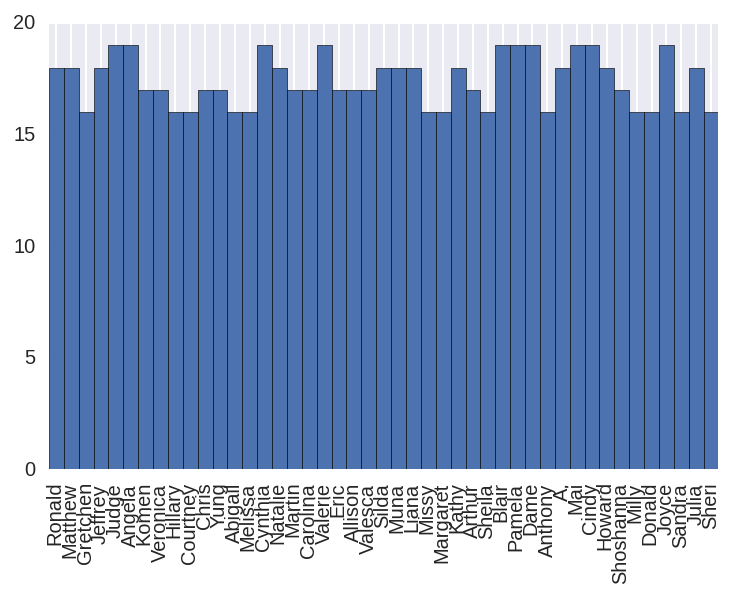

In [771]:
freq_thr = 15
freq_uthr = 20
import numpy as np
highfreq_keys = [pref for pref, rep in prefixes.items() if rep > freq_thr and rep < freq_uthr]
highfreq_vals = [prefixes[pref] for pref in highfreq_keys]
indexes = np.arange(len(highfreq_keys))
width = 1
plt.bar(indexes, highfreq_vals, width)
plt.xticks(indexes + width * 0.5, highfreq_keys, rotation='vertical')

# Graph analysis

In [819]:
import itertools
from collections import defaultdict
#from sets import Set
edges = defaultdict(int)
for cap in my_captions:
    if len(cap) > 250:
        continue   
    tokens_withnull = re.split(',\ and\ |\ and\ |,\ with\ |\ with\ |,\ ', cap)
    tokens = [token for token in tokens_withnull if token != '']
    peeps = get_names(tokens)
    peeps.sort()
    peeps_edges = itertools.combinations(peeps, 2)
    for p in peeps_edges:
        edges[p] += 1
#tt = Set(peeps_edges)

In [826]:
import networkx as nx
from operator import itemgetter
G = nx.MultiGraph()
for pair, num_pic in edges.iteritems():
    G.add_edge(pair[0], pair[1], weight=num_pic)
#top_degrees = sorted(G.degree_iter(), key=itemgetter(1), reverse=True)
top_degrees = sorted(G.degree_iter(weight='weight'), key=itemgetter(1), reverse=True)


In [877]:
import pandas as pd
degrees100 = [name_deg[1] for deg_pos, name_deg  in enumerate(top_degrees) if deg_pos < 100]
pd.DataFrame(degrees100).describe()


,0
count,100.000000
mean,148.910000
std,71.449084
min,96.000000
25%,106.750000
50%,123.000000
75%,158.250000
max,492.000000


In [874]:
# Top 100 degrees, return [('Alec Baldwin', 82)] * 100
i_deg = 0
for name, deg in top_degrees:
    if i_deg < 100:
        print("('{name}', {deg}), ".format(name = name, deg = deg))
        i_deg += 1
    else:
        break

('Jean Shafiroff', 492), 
('Gillian Miniter', 429), 
('Mark Gilbertson', 429), 
('Alexandra Lebenthal', 303), 
('Somers Farkas', 292), 
('Andrew Saffir', 281), 
('Geoffrey Bradfield', 278), 
('Debbie Bancroft', 266), 
('Jamee Gregory', 234), 
('Alina Cho', 229), 
('Yaz Hernandez', 226), 
('Eleanora Kennedy', 224), 
('Kamie Lightburn', 222), 
('Sharon Bush', 216), 
('Mario Buatta', 193), 
('Bettina Zilkha', 190), 
('Barbara Tober', 189), 
('Bonnie Comley', 179), 
('Daniel Benedict', 178), 
('Lydia Fenet', 177), 
('Lucia Hwong Gordon', 177), 
('Allison Aston', 175), 
('Muffie Potter Aston', 174), 
('Sylvester Miniter', 164), 
('Stewart Lane', 159), 
('Grace Meigher', 158), 
('Dennis Basso', 158), 
('Jennifer Creel', 153), 
('Michael Bloomberg', 152), 
('Deborah Norville', 144), 
('Liz Peek', 144), 
('Nicole Miller', 141), 
('Martha Stewart', 141), 
('Felicia Taylor', 140), 
('Kipton Cronkite', 140), 
('Fe Fendi', 139), 
('Patrick McMullan', 139), 
('Amy Fine Collins', 138), 
('Roric Tobi

In [879]:
# Top 100 degrees NOT RIGHT, return [('Alec Baldwin', 82)] * 100
m1=148.91
m2=109.96
sd1=71.449084
sd2=52.477782
i_deg = 0
for name, deg in top_degrees:
    if i_deg < 100:
        deg = int(round(m2+(deg-m1)*(sd2/sd1)))
        print("('{name}', {deg}), ".format(name = name, deg = deg))
        i_deg += 1
    else:
        break

('Jean Shafiroff', 362), 
('Gillian Miniter', 316), 
('Mark Gilbertson', 316), 
('Alexandra Lebenthal', 223), 
('Somers Farkas', 215), 
('Andrew Saffir', 207), 
('Geoffrey Bradfield', 205), 
('Debbie Bancroft', 196), 
('Jamee Gregory', 172), 
('Alina Cho', 169), 
('Yaz Hernandez', 167), 
('Eleanora Kennedy', 165), 
('Kamie Lightburn', 164), 
('Sharon Bush', 159), 
('Mario Buatta', 142), 
('Bettina Zilkha', 140), 
('Barbara Tober', 139), 
('Bonnie Comley', 132), 
('Daniel Benedict', 131), 
('Lydia Fenet', 131), 
('Lucia Hwong Gordon', 131), 
('Allison Aston', 129), 
('Muffie Potter Aston', 128), 
('Sylvester Miniter', 121), 
('Stewart Lane', 117), 
('Grace Meigher', 117), 
('Dennis Basso', 117), 
('Jennifer Creel', 113), 
('Michael Bloomberg', 112), 
('Deborah Norville', 106), 
('Liz Peek', 106), 
('Nicole Miller', 104), 
('Martha Stewart', 104), 
('Felicia Taylor', 103), 
('Kipton Cronkite', 103), 
('Fe Fendi', 103), 
('Patrick McMullan', 103), 
('Amy Fine Collins', 102), 
('Roric Tobi

In [867]:
# Convert to standard graph
H = nx.Graph()
for u,v,d in G.edges(data=True):
    w = d['weight']
    if H.has_edge(u,v):
        H[u][v]['weight'] += w
    else:
        H.add_edge(u,v,weight=w)
ranks = nx.pagerank(H)

In [868]:
top_ranks = sorted( ((v,k) for k,v in ranks.iteritems()), reverse=True)

In [871]:

top_ranks[1]

(0.000540017819528407, u'Mark Gilbertson')

In [873]:
# Top 100 ranks, return [('Martha Stewart', 0.00019312108706213307)]
i_rank = 0
for rank, name in top_ranks:
    if i_rank < 100:
        print("('{name}', {rank}), ".format(name = name, rank = rank))
        i_rank += 1
    else:
        break

('Jean Shafiroff', 0.000616106661333), 
('Mark Gilbertson', 0.000540017819528), 
('Gillian Miniter', 0.000437458647635), 
('Andrew Saffir', 0.000399161043153), 
('Alexandra Lebenthal', 0.000358482987014), 
('Geoffrey Bradfield', 0.000351606036128), 
('Somers Farkas', 0.000331850960353), 
('Debbie Bancroft', 0.000321741575695), 
('Mario Buatta', 0.000294121406328), 
('Alina Cho', 0.000293448079766), 
('Sharon Bush', 0.00029040912915), 
('Kamie Lightburn', 0.000286624903496), 
('Yaz Hernandez', 0.00027115320995), 
('Barbara Tober', 0.000270391837466), 
('Eleanora Kennedy', 0.0002488096465), 
('Jamee Gregory', 0.00024719313201), 
('Lucia Hwong Gordon', 0.000246758225436), 
('Lydia Fenet', 0.000238185465322), 
('Michael Bloomberg', 0.000232759256856), 
('Bettina Zilkha', 0.00022697415421), 
('Patrick McMullan', 0.000224957322527), 
('Daniel Benedict', 0.000219462265466), 
('Bonnie Comley', 0.000213809412226), 
('Kipton Cronkite', 0.00021348884543), 
('Allison Aston', 0.000209217852639), 
(

In [859]:
top_edges = sorted(G.edges(data = True), key = lambda (a, b, dct): dct['weight'], reverse=True)
edges100 = [name1_name2_weight[2]['weight'] for edge_pos, name1_name2_weight  in enumerate(top_edges) if edge_pos < 100 ]

In [858]:
edges100[0]

{'weight': 106}

In [860]:
pd.DataFrame(edges100).describe()

,0
count,100.000000
mean,23.680000
std,15.066774
min,13.000000
25%,14.750000
50%,18.000000
75%,25.000000
max,106.000000


In [875]:
# Top 100 edges
# return [(('Michael Kennedy', 'Eleanora Kennedy'), 41)] * 100
i_edge = 0
for a, b, dct in top_edges:
    if i_edge < 100:
        print("(('{a}', '{b}'), {w}), ".format(a = a, b = b, w = dct['weight']))
        i_edge += 1
    else:
        break

(('Gillian Miniter', 'Sylvester Miniter'), 106), 
(('Jamee Gregory', 'Peter Gregory'), 73), 
(('Bonnie Comley', 'Stewart Lane'), 68), 
(('Andrew Saffir', 'Daniel Benedict'), 64), 
(('Roric Tobin', 'Geoffrey Bradfield'), 54), 
(('Martin Shafiroff', 'Jean Shafiroff'), 49), 
(('Jay Diamond', 'Alexandra Lebenthal'), 49), 
(('Somers Farkas', 'Jonathan Farkas'), 49), 
(('Donald Tober', 'Barbara Tober'), 47), 
(('Campion Platt', 'Tatiana Platt'), 46), 
(('Chappy Morris', 'Melissa Morris'), 40), 
(('Chris Meigher', 'Grace Meigher'), 38), 
(('Michael Kennedy', 'Eleanora Kennedy'), 38), 
(('Lizzie Tisch', 'Jonathan Tisch'), 36), 
(('Yaz Hernandez', 'Valentin Hernandez'), 35), 
(('Peter Regna', 'Barbara Regna'), 35), 
(('Deborah Norville', 'Karl Wellner'), 34), 
(('John Catsimatidis', 'Margo Catsimatidis'), 33), 
(('Wilbur Ross', 'Hilary Geary Ross'), 31), 
(('Arie Kopelman', 'Coco Kopelman'), 31), 
(('Elizabeth Stribling', 'Guy Robinson'), 31), 
(('Douglas Hannant', 'Frederick Anderson'), 30), 


# Extra (can be deleted later)

In [415]:
def valid_name(words):
    return all(w.istitle() or w.isupper() or w in ['bin', 'bint', 'van'] for w in words.split())
tt = 'HRH Prince Abdulaziz bin Talal bin Abdulaziz Al-Saud and HH Princess Sora bint Saud'
re_pair = re.split(' and ', tt)
peeps=[]
if len(re_pair)==2 and ',' not in re_pair[0]:
    if valid_name(re_pair[0]) and valid_name(re_pair[1]):
        peeps += [re_pair[0]]
        peeps += [re_pair[1]]
print peeps

['HRH Prince Abdulaziz bin Talal bin Abdulaziz Al-Saud', 'HH Princess Sora bint Saud']


In [ ]:
from colorama import Fore
import re

In [430]:
a=['abd', 'asdf']
print "People found: %s" % a

People found: ['abd', 'asdf']


In [259]:
from collections import Counter
import nltk

#for icap, cap in enumerate(caps1):
#    if 'after sharing her story of the grueling end-of-life experiences' in cap:
#        print icap, cap

tagged = nltk.pos_tag(nltk.word_tokenize(caps1[612]))

for icap, cap in enumerate(caps1):
    tagged = nltk.pos_tag(nltk.word_tokenize(cap))
    counts = Counter(tag for word, tag in tagged)
    VB_count = 0
    for key, value in counts.iteritems():   # iter on both keys and values
        if key.startswith('VB'):
            VB_count += value
    if VB_count > 3:
        print VB_count, icap, cap, len(cap)


4 527 Robert Matheson squires his grandmother, Ruth Buchanan, and her favorite dachshund, Cinderella, across the porch to receive guests for an event for friends and family to learn more about the work of leading national nonprofit Compassion & Choices. 247
22 604 Mother and daughter co-hosts (R-L) Ruth Buchanan and Bonnie Matheson. Ruth told her guests: "I watched both of my late husbands have terribly painful and drawn-out deaths because they didn't plan ahead [by naming resolute healthcare proxies and completing comprehensive advance directives]. They hadn't spoken to their families about their own deeply held end-of-life values and shared what truly living meant to them. I hope each of you — including my own children and grandchildren — gathered here will not make the same mistakes. Life for me is more than just existing, and I don't want to be here if I can't truly enjoy all of it — especially dancing!" 656
4 606 L-R Ronald Fleming, his guest Phoebe visiting for the season from En

In [255]:
print caps1[633]

Jared Hughes sets up the Sundance Award Winning film, and how it came to be made and speaks about the work of Compassion & Choices which it chronicles.


In [250]:
tagged = nltk.pos_tag(nltk.word_tokenize(caps1[612]))
counts = Counter(tag for word, tag in tagged)
print counts

Counter({'NNP': 33, 'NN': 18, 'IN': 9, 'CC': 7, 'NNS': 6, 'JJ': 5, 'DT': 4, 'VBD': 3, '.': 3, ':': 3, 'PRP$': 2, 'VBG': 2, ',': 2, "''": 2, 'TO': 2, 'PRP': 2, 'VB': 2, 'CD': 2, 'VBP': 1, 'WP': 1, 'POS': 1, 'RB': 1, 'MD': 1, 'JJR': 1})


In [244]:
for sent in nltk.sent_tokenize(caps1[612]):
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))): 
        if not hasattr(chunk, 'node'):
            print chunk

(ORGANIZATION Hostess/NNP Ruth/NNP Buchanan/NNP)
(u'(', 'NNP')
(u'pink', 'NN')
(u'suit', 'NN')
(u')', ':')
(u'listens', 'NNS')
(u'to', 'TO')
(ORGANIZATION Compassion/NNP)
(u'&', 'CC')
(PERSON Choices/NNP)
(u"'", "''")
(u'Chief', 'NNP')
(u'Program', 'NNP')
(u'Officer', 'NNP')
(PERSON Mickey/NNP MacIntyre/NNP)
(u"'s", 'POS')
(u'response', 'NN')
(u'after', 'IN')
(u'sharing', 'VBG')
(u'her', 'PRP')
(u'story', 'NN')
(u'of', 'IN')
(u'the', 'DT')
(u'grueling', 'NN')
(u'end-of-life', 'NN')
(u'experiences', 'NNS')
(u'of', 'IN')
(u'two', 'CD')
(u'of', 'IN')
(u'her', 'PRP$')
(u'late', 'JJ')
(u'husbands', 'NNS')
(u'with', 'IN')
(PERSON Brown/NNP University/NNP Art/NNP History/NNP Professor/NNP)
(u'and', 'CC')
(u'longtime', 'VB')
(ORGANIZATION Compassion/NNP)
(u'&', 'CC')
(GPE Choices/NNP)
(u'friend', 'NN')
(PERSON Anne/NNP Schultz/NNP)
(u',', ',')
(u'and', 'CC')
(PERSON Patricia/NNP)
(u'Norton-Kidder', 'NNP')
(u'of', 'IN')
(u'the', 'DT')
(ORGANIZATION Newport/NNP Hospital/NNP Advisory/NNP Committe

In [260]:
from colorama import Fore
import re

s = "This is a sentence where I talk about interesting stuff like sencha tea."
print re.sub(r'(sen\w+)', Fore.RED + r'\1' + Fore.RESET, s)

This is a sentence where I talk about interesting stuff like sencha tea.
